Based on: https://www.sdss.org/dr13/spectro/galaxy_granada/

In [2]:
import numpy as np
import pandas as pd
from astropy.io import ascii
from scipy import stats
from scipy.optimize import minimize,curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from multiprocessing import Pool
np.random.seed(9620)
sns.set(style='ticks', context='talk')
plt.style.use("../paper.mplstyle")

# from snpy import get_sn
from tqdm import tqdm

from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u

from warnings import filterwarnings
filterwarnings(action='ignore')

# Granada Group: DR8 

In [2]:
from astropy.table import Table
table_granada = Table.read('granada_fsps_krou_wideform_nodust-26.fits')
x = table_granada['AGE'].data.astype(np.float)
y = table_granada['LOGMASS'].data.astype(np.float)
print(len(x))

943001


In [53]:
table_granada.columns

<TableColumns names=('PLATE','MJD','FIBERID','RA','DEC','Z','Z_ERR','ZNUM','MAGSCALED','MAGSCALED_ERR','KE','CMODELABSMAG','M2L','M2L_MEDIAN','M2L_ERR','M2L_MIN','M2L_MAX','LOGMASS','LOGMASS_MEDIAN','LOGMASS_ERR','LOGMASS_MIN','LOGMASS_MAX','CHI2','DELTA_CHI2','NFILTER','PARAM','PARAM_MEAN','PARAM_ERR','PARAM_MIN','PARAM_MAX','AGE','AGE_MEAN','AGE_MIN','AGE_MAX','SSFR','SSFR_MEAN','SSFR_MIN','SSFR_MAX','WARNING','LEGACY_TARGET1','LEGACY_TARGET2','SPECIAL_TARGET1','SPECIAL_TARGET2','BOSS_TARGET1','BOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','SPECPRIMARY','SPECOBJID')>

No handles with labels found to put in legend.


(8.0, 13.0)

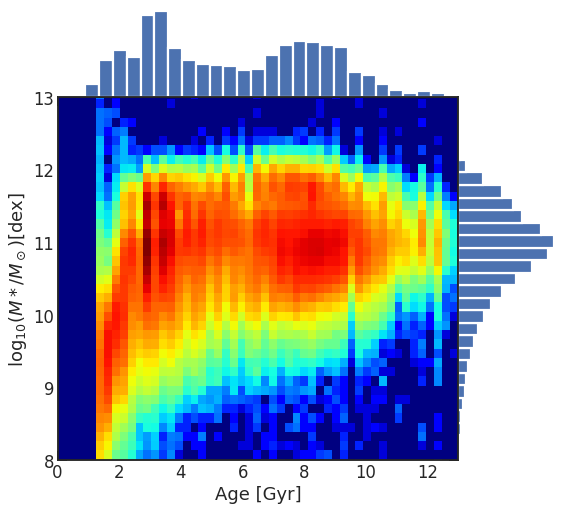

<Figure size 720x720 with 0 Axes>

In [14]:
# data prep
age = x
mass = y

# set up figure
fig = plt.figure(figsize=(8,7))
gs = gridspec.GridSpec(2,2, height_ratios=[0.2,0.8], width_ratios=[0.8,0.2])
gs.update(left=0.12, right=0.99, bottom=0.09, top=0.99, wspace=0., hspace=0.)
ax1 = fig.add_subplot(gs[1,0]) # main
ax2 = fig.add_subplot(gs[0,0]) # top
ax3 = fig.add_subplot(gs[1,1]) # right

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax2.set_yticks([])
ax3.set_xticks([])
ax2.set_xticks([])
ax3.set_yticks([])
ax1.tick_params(top=True,right=True,which='both')

## main plot
plt.figure(figsize=(10,10))
cmap = mpl.cm.jet
cmap.set_bad(cmap(0))
ax1.hist2d(x,y,range=[[0,14],[7,14]],bins=55,cmap=cmap,norm=mpl.colors.LogNorm());
ax1.legend(frameon=False)
ax1.set_xlim(0,13)
ax1.set_ylim(8,13)
ax1.set_xlabel(r'Age [Gyr]')
ax1.set_ylabel(r'$\log_{10}(M*/M_\odot)$[dex]')

## top hist
ax2.hist(age,bins=np.linspace(0,13,30))
ax2.set_xlim(0,13)

## right hist
ax3.hist(mass,orientation='horizontal',bins=np.linspace(8,13,30))
ax3.set_ylim(8,13)

# plt.savefig('figures/mass-age-correlation.pdf',bbox_to_inches='tight')

# Portsmouth Group: DR8

In [3]:
table_portsmouth = Table.read('portsmouth_stellarmass_starforming_krou-26.fits')
x = table_portsmouth['AGE'].data.astype(np.float)
y = table_portsmouth['LOGMASS'].data.astype(np.float)

print(len(x))

943001


No handles with labels found to put in legend.


(8.0, 13.0)

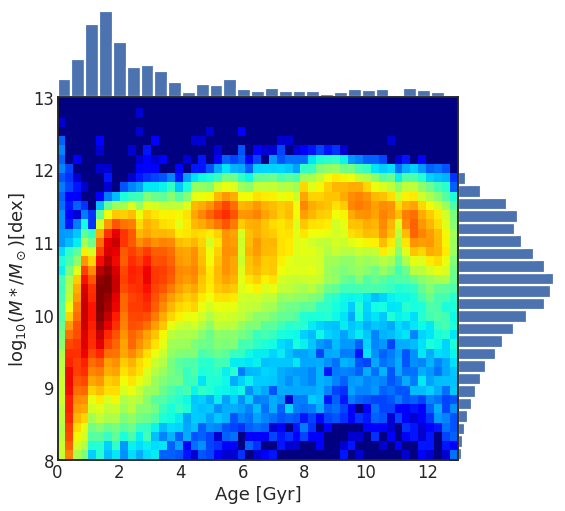

<Figure size 720x720 with 0 Axes>

In [11]:
# data prep
age = x
mass = y

# set up figure
fig = plt.figure(figsize=(8,7))
gs = gridspec.GridSpec(2,2, height_ratios=[0.2,0.8], width_ratios=[0.8,0.2])
gs.update(left=0.12, right=0.99, bottom=0.09, top=0.99, wspace=0., hspace=0.)
ax1 = fig.add_subplot(gs[1,0]) # main
ax2 = fig.add_subplot(gs[0,0]) # top
ax3 = fig.add_subplot(gs[1,1]) # right

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax2.set_yticks([])
ax3.set_xticks([])
ax2.set_xticks([])
ax3.set_yticks([])
ax1.tick_params(top=True,right=True,which='both')

## main plot
plt.figure(figsize=(10,10))
cmap = mpl.cm.jet
cmap.set_bad(cmap(0))
ax1.hist2d(x,y,range=[[0,14],[7,14]],bins=55,cmap=cmap,norm=mpl.colors.LogNorm());
ax1.legend(frameon=False)
ax1.set_xlim(0,13)
ax1.set_ylim(8,13)
ax1.set_xlabel(r'Age [Gyr]')
ax1.set_ylabel(r'$\log_{10}(M*/M_\odot)$[dex]')

## top hist
ax2.hist(age,bins=np.linspace(0,13,30))
ax2.set_xlim(0,13)

## right hist
ax3.hist(mass,orientation='horizontal',bins=np.linspace(8,13,30))
ax3.set_ylim(8,13)

# plt.savefig('figures/mass-age-correlation.pdf',bbox_to_inches='tight')

# check scatter & disagreements

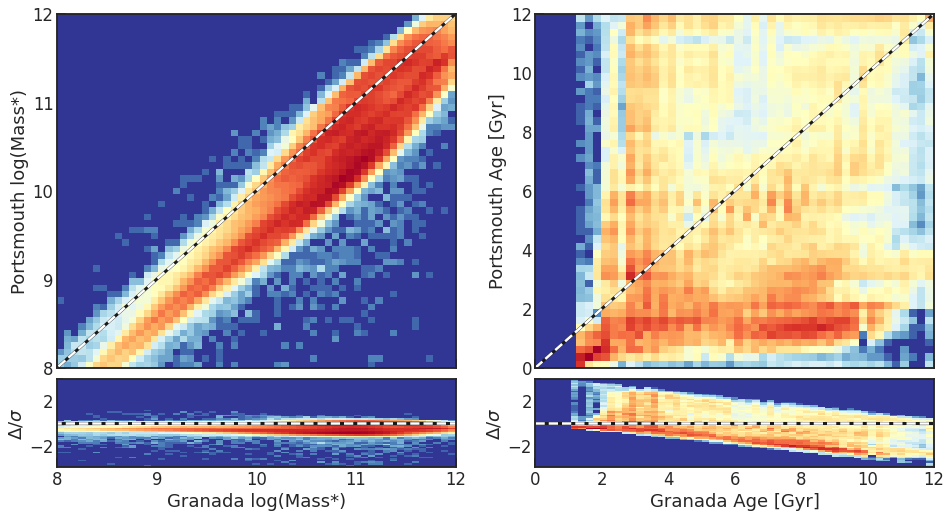

In [49]:
# mass bias & disagreement plot
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(2,2, height_ratios=[0.8,0.2],width_ratios=[0.5,0.5])
gs.update(left=0.12, right=0.99, bottom=0.09, top=0.99, wspace=0.2, hspace=0.05)
cmap = mpl.cm.RdYlBu_r
cmap.set_bad(cmap(0))

x = table_granada['LOGMASS'].data.astype(np.float)
y = table_portsmouth['LOGMASS'].data.astype(np.float)

# mass
ax1 = fig.add_subplot(gs[0,0]) # main
ax2 = fig.add_subplot(gs[1,0]) # diff
ax1.hist2d(x,y,range=[[8,12],[8,12]],bins=55,cmap=cmap,norm=mpl.colors.LogNorm())#s=1)
ax1.plot([0,15],[0,15],color='k',linestyle='-',lw=3,alpha=1,zorder=2)
ax1.plot([0,15],[0,15],color='white',linestyle='--',lw=2.5,alpha=1,zorder=2)
ax1.set_xlim(8,12)
ax1.set_ylim(8,12)
ax1.set_yticks([8,9,10,11,12])
ax1.set_xticklabels([])

# m = table_portsmouth['LOGMASS'].replace([np.inf, -np.inf], np.nan)
std = np.std(y)
ax2.hist2d(x,(y-x)/std,range=[[8,12],[-4,4]],bins=55,cmap=cmap,norm=mpl.colors.LogNorm())#s=1);
ax2.plot([0,15],[0,0],color='k',linestyle='-',lw=3,alpha=1,zorder=1)
ax2.plot([0,15],[0,0],color='white',linestyle='--',lw=2.5,alpha=1,zorder=2)
ax2.set_xlim(8,12)
ax2.set_xticks([8,9,10,11,12])
ax1.set_ylabel(r'Portsmouth log(Mass*)')
ax2.set_xlabel(r'Granada log(Mass*)')
ax2.set_ylabel(r'$\Delta/\sigma$')
ax2.set_ylim(-4,4)
ax2.set_yticks([-2,2])

# age
x = table_granada['AGE'].data.astype(np.float)
y = table_portsmouth['AGE'].data.astype(np.float)
ax3 = fig.add_subplot(gs[0,1]) # main
ax4 = fig.add_subplot(gs[1,1]) # diff
ax3.hist2d(x,y,bins=48,range=[[0,12],[0,12]],cmap=cmap,norm=mpl.colors.LogNorm())#,s=1)
ax3.plot([0,15],[0,15],color='k',linestyle='-',lw=3,alpha=1,zorder=2)
ax3.plot([0,15],[0,15],color='white',linestyle='--',lw=2.5,alpha=1,zorder=2)
ax3.set_xlim(0,12)
ax3.set_ylim(0,12)
ax3.set_xticklabels([])

std = np.std(y)
ax4.hist2d(x,(y-x)/std,range=[[0,12],[-4,4]],bins=55,cmap=cmap,norm=mpl.colors.LogNorm())#,s=1);
ax4.plot([0,15],[0,0],color='k',linestyle='-',lw=3,alpha=1,zorder=1)
ax4.plot([0,15],[0,0],color='white',linestyle='--',lw=2.5,alpha=1,zorder=2)

ax4.set_xlim(0,12)
ax3.set_ylabel(r'Portsmouth Age [Gyr]')
ax4.set_xlabel(r'Granada Age [Gyr]')
ax4.set_ylabel(r'$\Delta/\sigma$')
ax4.set_ylim(-4,4)
ax4.set_yticks([-2,2])

# GZOO

In [4]:
from astropy.table import Table
table_ZOO = Table.read('zoo2MainSpecz.fits')
table_ZOO[:3]

specobjid,dr8objid,dr7objid,ra,dec,rastring,decstring,sample,gz2class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t06_odd_a14_yes_weighted_fraction,t06_odd_a14_yes_debiased,t06_odd_a14_yes_flag,t06_odd_a15_no_count,t06_odd_a15_no_weight,t06_odd_a15_no_fraction,t06_odd_a15_no_weighted_fraction,t06_odd_a15_no_debiased,t06_odd_a15_no_flag,t07_rounded_a16_completely_round_count,t07_rounded_a16_completely_round_weight,t07_rounded_a16_completely_round_fraction,t07_rounded_a16_completely_round_weighted_fraction,t07_rounded_a16_completely_round_debiased,t07_rounded_a16_completely_round_flag,t07_rounded_a17_in_between_count,t07_rounded_a17_in_between_weight,t07_rounded_a17_in_between_fraction,t07_rounded_a17_in_between_weighted_fraction,t07_rounded_a17_in_between_debiased,t07_rounded_a17_in_between_flag,t07_rounded_a18_cigar_shaped_count,t07_rounded_a18_cigar_shaped_weight,t07_rounded_a18_cigar_shaped_fraction,t07_rounded_a18_cigar_sha

# Combine data

In [9]:
# convert to df
df_granada = table_granada[['SPECOBJID','LOGMASS','AGE','Z']].to_pandas()
df_portsmouth = table_portsmouth[['SPECOBJID','LOGMASS','AGE','Z']].to_pandas()
df_gzoo = table_ZOO[['t05_bulge_prominence_a10_no_bulge_debiased',
                    't05_bulge_prominence_a12_obvious_debiased',
                    't05_bulge_prominence_a13_dominant_debiased']].to_pandas()
df_gzoo['SPECOBJID'] = table_ZOO['specobjid'].astype(str)
df_gzoo = df_gzoo.set_index('SPECOBJID')

# rename columns
df_granada = df_granada.rename(columns={'LOGMASS':'LOGMASS_granada','AGE':'AGE_granada','Z':'Z_granada'}).set_index('SPECOBJID')
df_portsmouth = df_portsmouth.rename(columns={'LOGMASS':'LOGMASS_portsmouth','AGE':'AGE_portsmouth','Z':'Z_portsmouth'}).set_index('SPECOBJID')
df_gzoo = df_gzoo.rename(columns={
    't05_bulge_prominence_a10_no_bulge_debiased':'p_nobulge',
    't05_bulge_prominence_a12_obvious_debiased':'p_obvious',
    't05_bulge_prominence_a13_dominant_debiased':'p_dominant'
})

In [10]:
# combine granada + portsmouth
df_combined = df_granada.copy()
df_combined = df_combined.combine_first(df_portsmouth)
df_combined.index = df_combined.index.values
df_combined.index = np.char.strip(df_combined.index.values.astype(np.str))

# combine gzoo & calculate ttype
df_combined = df_combined.combine_first(df_gzoo)
df_combined['gz_ttype'] = 4.63 + 4.17*df_combined['p_nobulge'] - 2.27*df_combined['p_obvious'] - 8.38*df_combined['p_dominant']

# checkpoint -- start here

In [3]:
# select rows with full data
# df_combined.to_csv('DR8_GZoo+Granada+Portsmouth.csv',index=True)
df_combined = pd.read_csv('DR8_GZoo+Granada+Portsmouth.csv')
df_combined = df_combined.rename(columns={'Unnamed: 0':'specobjid'}).set_index('specobjid')
df_final = df_combined[df_combined.isnull().sum(axis=1)==0]
# df_final.to_csv('DR8_GZoo+Granada+Portsmouth_cut.csv',index=True)

In [12]:
df_final

,AGE_granada,AGE_portsmouth,LOGMASS_granada,LOGMASS_portsmouth,Z_granada,Z_portsmouth,p_dominant,p_nobulge,p_obvious,gz_ttype
specobjid,,,,,,,,,,
1000925611616659456,2.314906,0.7187,9.055471,8.60,0.022912,0.022912,0.026063,0.255305,0.078530,5.297948
1000926161372473344,1.699199,0.4535,9.534988,8.97,0.039755,0.039755,0.000000,0.273579,0.136450,5.461081
1000932208686426112,8.588330,2.1000,11.185413,10.59,0.100159,0.100159,1.000000,0.000000,0.000000,-3.750000
1000933308198053888,11.789799,12.5000,11.378759,11.38,0.063111,0.063111,0.072098,0.000000,0.866763,2.058271
1000933583075960832,3.496192,2.7500,11.001720,10.85,0.063757,0.063757,0.185588,0.000000,0.656930,1.583538
...,...,...,...,...,...,...,...,...,...,...
999972604477466624,8.254525,1.2781,10.888333,10.11,0.111232,0.111232,0.000000,0.162091,0.086453,5.109671
999973703989094400,2.307769,4.5000,11.147625,11.16,0.106479,0.106479,0.000000,0.000000,0.400000,3.722000
999973978867001344,2.798041,2.7500,8.875703,8.50,0.015714,0.015714,0.000000,0.838336,0.000000,8.125861


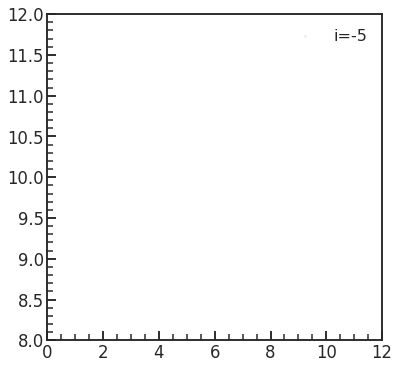

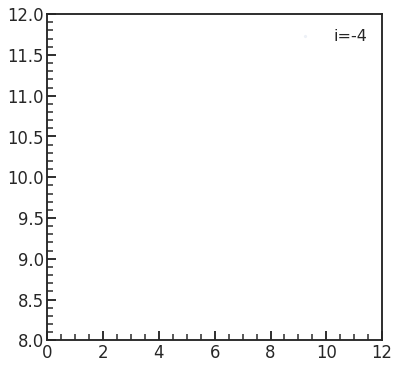

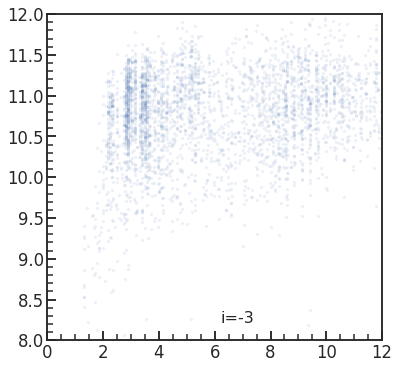

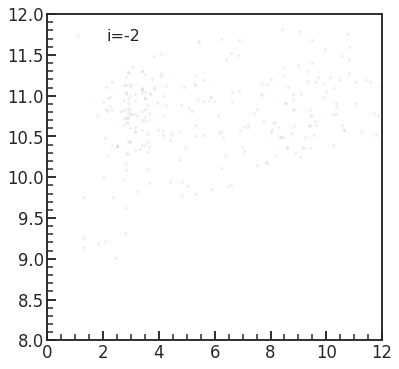

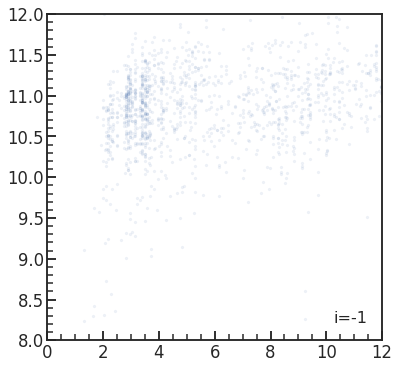

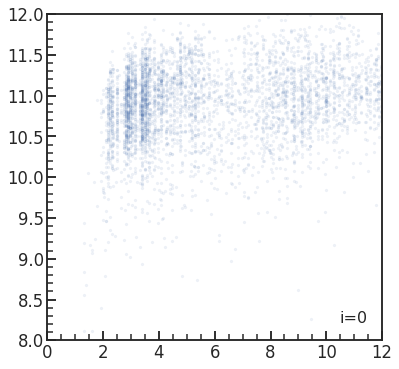

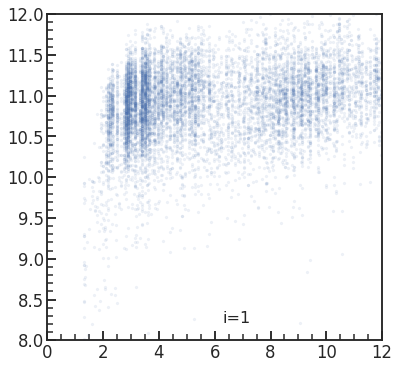

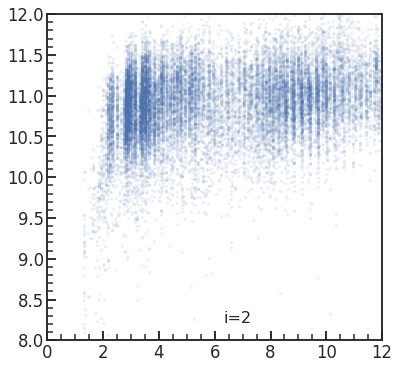

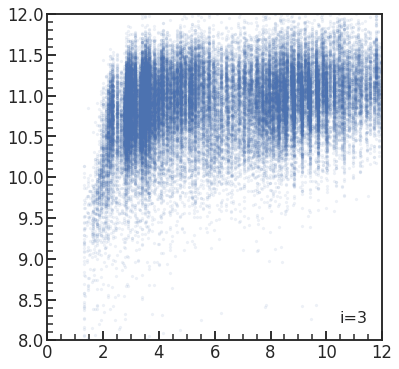

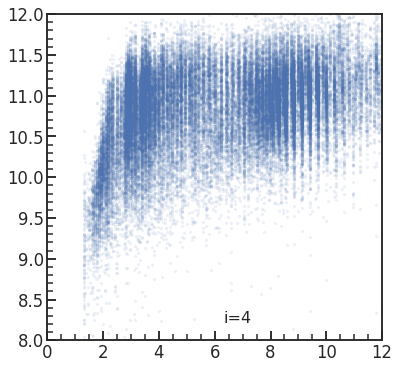

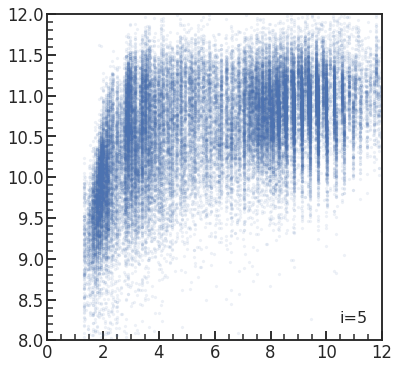

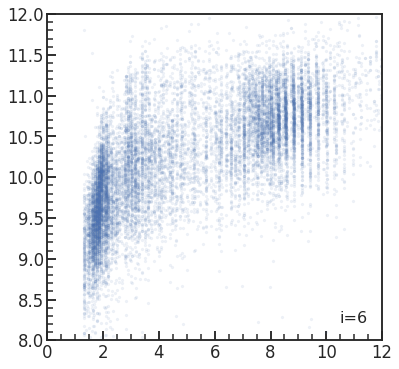

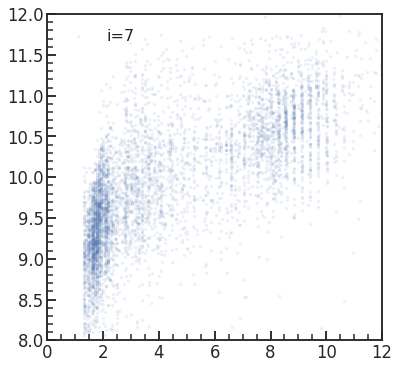

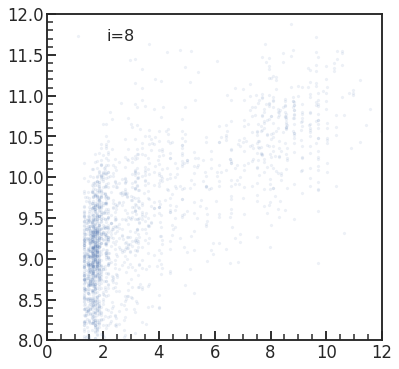

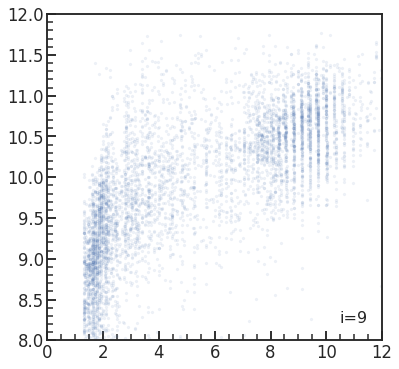

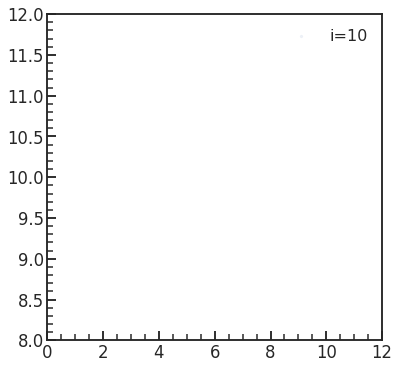

In [24]:
# distribution by ttype
for i in range(-5,11):
    plt.figure(figsize=(6,6))
    cut = (df_final['gz_ttype']>i-1) & (df_final['gz_ttype']<=i)
    plt.scatter(df_final[cut]['AGE_granada'],df_final[cut]['LOGMASS_granada'],s=1,alpha=0.1,label=f'i={i}')
    plt.legend()
    plt.xlim(0,12)
    plt.ylim(8,12)
    plt.show()

In [40]:
from scipy.stats import gaussian_kde as kde

def plot_by_T(attr,xlim=(0,14)):
    cm = plt.get_cmap('RdYlBu')
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
    for i in range(-5,11):
        cut = (df_final['gz_ttype']>i-1) & (df_final['gz_ttype']<=i)
        try:
            kernel = kde(df_final[cut][attr].values)
            age_th = np.linspace(0,14,100)
            dist = kernel(age_th)
            ax1.plot(age_th,dist*len(df_final[cut]),c=cm((i+5)/16),alpha=0.8)
            ax2.plot(age_th,dist/dist.max(),label=f'{i-1:2} < T '+r'$\leq$'+f'{i:2}',c=cm((i+5)/16),alpha=0.8)
        except:
            continue
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    ax1.set_xlabel(attr)
    ax1.set_xlim(xlim)
    ax2.set_xlabel(attr)
    ax2.set_xlim(xlim)
    ax1.set_title('truth to sample size',fontsize=14)
    ax2.set_title('normalized to equal height',fontsize=14)
    plt.show()

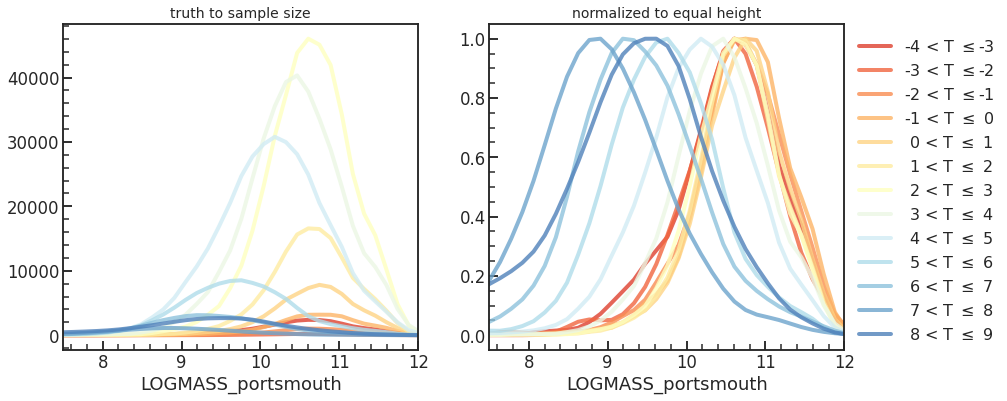

In [42]:
plot_by_T('LOGMASS_portsmouth',(7.5,12))

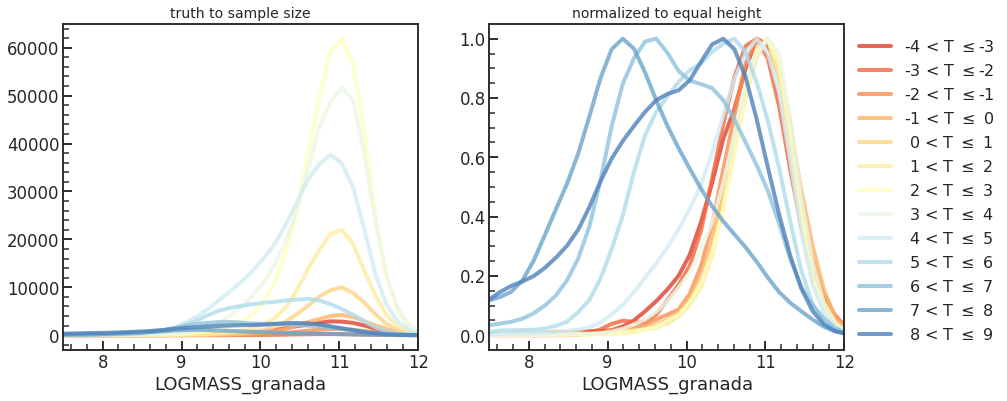

In [43]:
plot_by_T('LOGMASS_granada',(7.5,12))

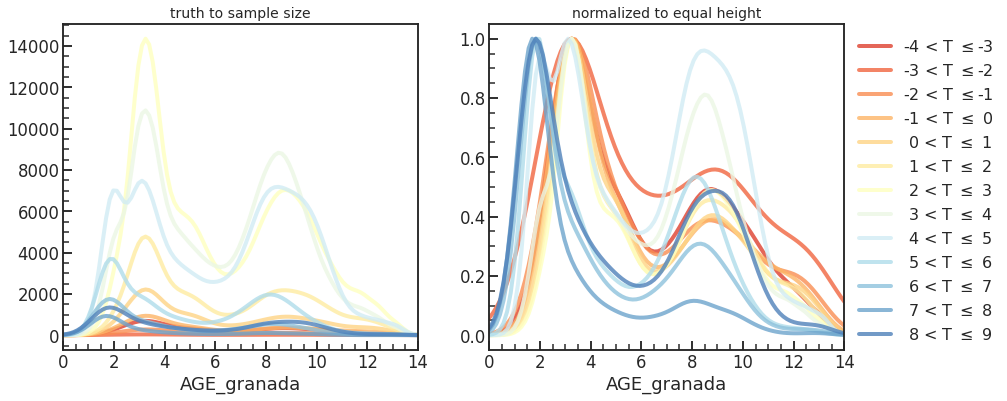

In [44]:
plot_by_T('AGE_granada',(0,14))

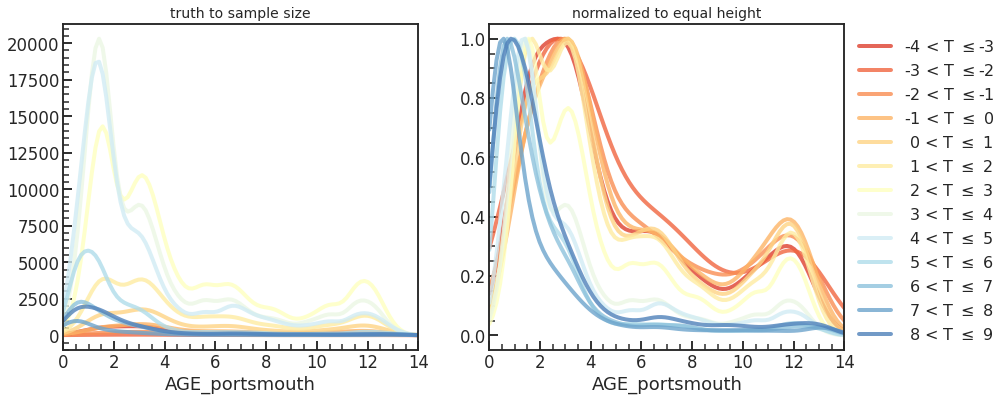

In [45]:
plot_by_T('AGE_portsmouth',(0,14))

In [16]:
df_final

,AGE_granada,AGE_portsmouth,LOGMASSS_granada,LOGMASSS_portsmouth,p_dominant,p_nobulge,p_obvious,gz_ttype
1000925611616659456,2.314906,0.7187,9.055471,8.60,0.026063,0.255305,0.078530,5.297948
1000926161372473344,1.699199,0.4535,9.534988,8.97,0.000000,0.273579,0.136450,5.461081
1000932208686426112,8.588330,2.1000,11.185413,10.59,1.000000,0.000000,0.000000,-3.750000
1000933308198053888,11.789799,12.5000,11.378759,11.38,0.072098,0.000000,0.866763,2.058271
1000933583075960832,3.496192,2.7500,11.001720,10.85,0.185588,0.000000,0.656930,1.583538
...,...,...,...,...,...,...,...,...
999972604477466624,8.254525,1.2781,10.888333,10.11,0.000000,0.162091,0.086453,5.109671
999973703989094400,2.307769,4.5000,11.147625,11.16,0.000000,0.000000,0.400000,3.722000
999973978867001344,2.798041,2.7500,8.875703,8.50,0.000000,0.838336,0.000000,8.125861
999974528622815232,3.146847,0.4535,9.905416,9.17,0.133767,0.161584,0.000000,4.182834
